이번 글에서는 데이터 기반 의사 결정(Data-Driven Decision Making)에 대해 이야기해 보려고 합니다.  데이터 기반 의사 결정은 객관적인 데이터를 분석하고 해석하여 결정을 내리는 방식으로 직관이나 경험에 의존하는 것보다 더욱 합리적인 판단을 가능하게 하여 연구 및 비즈니스 분야에서 그 중요성이 점점 커지고 있습니다.

하지만 실제 데이터를 수집하다 보면 변수(차원)가 지나치게 많아져 어떤 변수가 실제로 중요한 영향을 미치는지 파악하기 어려울 때가 많습니다. 이럴 때는 고차원 데이터의 차원을 축소하여 시각화하면 숨겨진 패턴을 발견하고 의사 결정에 도움을 얻을 수 있습니다. 따라서 이번 글에서는 항체 후보 물질 분석 사례를 통해 데이터 기반 의사 결정 시 시각화가 어떻게 기여하는지 구체적으로 살펴보겠습니다.

# 분석 예시

신약 개발은 막대한 비용이 소요되므로, 각 단계에서 효과적으로 후보 물질의 수를 줄여나가는 것이 매우 중요합니다. 여기서 핵심적인 질문은 **"어떻게 효율적으로 후보군을 압축할 수 있는가?"**입니다. 예시로, 항체 후보 물질들의 다양한 특성 데이터를 확보했다는 가정 하에, 각 후보 물질이 어떤 군집에 속하는지 확인하고 우리가 원하는 신약의 특성을 가진 군집을 찾아내는 방법을 설명하고자 합니다.

## 예시 데이터 생성

우선 예시 데이터를 임의로 생성하겠습니다. 실제로는 실험을 통해 데이터를 얻어야 합니다. 그런 다음 데이터 분석 시 분석 결과의 편향을 방지하기 위해 각 데이터를 정규화하는 과정이 필요합니다. 이는 수집된 데이터의 종류에 따라 값의 범위가 다르기 때문에 발생하는 문제를 해결하기 위함입니다.

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import fcluster, linkage, to_tree
from scipy.spatial.distance import pdist

nord_colors = ["#BF616A", "#D08770", "#EBCB8B", "#A3BE8C", "#B48EAD"]


def generate_candidate_dataframe(num_candidates):
    """주어진 개수의 후보 물질에 대한 가짜 데이터를 생성하고 DataFrame을 반환합니다."""

    candidates = [f"mAb{i}" for i in range(1, num_candidates + 1)]

    data = {
        "SEC_main": np.random.normal(loc=10, scale=2, size=num_candidates),
        "SEC_RT": np.random.normal(loc=5, scale=1, size=num_candidates),
        "pI": np.random.uniform(low=4, high=9, size=num_candidates),
        "HIC_RT": np.random.normal(loc=7, scale=1.5, size=num_candidates),
        "AC_SIN_Ace": np.random.normal(loc=0.5, scale=0.1, size=num_candidates),
        "AC_SINS_PBS": np.random.normal(loc=0.7, scale=0.1, size=num_candidates),
        "PSR": np.random.normal(loc=100, scale=15, size=num_candidates),
        "ELISA": np.random.normal(loc=200, scale=30, size=num_candidates),
        "BVP": np.random.normal(loc=0.8, scale=0.2, size=num_candidates),
        "Tm": np.random.normal(loc=70, scale=5, size=num_candidates),
        "Tagg": np.random.normal(loc=75, scale=6, size=num_candidates),
        "DSR": np.random.normal(loc=0.3, scale=0.05, size=num_candidates),
        "KD": np.random.normal(loc=1e-9, scale=1e-10, size=num_candidates),
        "CE_SDS": np.random.normal(loc=1, scale=0.2, size=num_candidates),
        "Titer": np.random.normal(loc=5, scale=1, size=num_candidates),
    }

    return pd.DataFrame(data, index=candidates)


# 데이터프레임 생성
df = generate_candidate_dataframe(24)
df.head()


,SEC_main,SEC_RT,pI,HIC_RT,AC_SIN_Ace,AC_SINS_PBS,PSR,ELISA,BVP,Tm,Tagg,DSR,KD,CE_SDS,Titer
mAb1,7.716622,4.533963,6.248699,7.440337,0.561915,0.711327,84.064097,225.218601,0.974259,71.659902,74.373305,0.287697,1.031917e-09,1.322444,3.856274
mAb2,9.612681,3.405297,7.883553,4.965127,0.705750,0.556172,106.424606,216.402007,0.530804,70.952498,73.987070,0.257838,1.134045e-09,1.179368,5.108560
mAb3,8.566355,5.513600,4.326831,7.699645,0.502079,0.791923,97.192836,192.832037,0.825276,73.547259,75.420313,0.408547,8.124828e-10,0.946294,4.966770
mAb4,6.266927,4.467299,6.437856,6.946538,0.427200,0.633186,114.785950,188.995268,1.187786,67.822568,81.971270,0.291206,1.011503e-09,0.821762,4.791883
mAb5,9.834639,3.830083,4.168068,4.577302,0.481710,0.887330,117.810791,188.247256,0.599934,72.565529,69.435881,0.306160,9.839867e-10,0.569637,4.871462


앞서 제시된 테이블을 보면 각 후보 항체에 대해 다양한 실험을 통해 얻은 데이터 값들이 나열되어 있는 것을 확인할 수 있습니다. 이때 어떤 항체가 우리가 원하는 특성을 갖추고 있는지 명확히 판단하기 어렵다는 점을 쉽게 이해하실 수 있을 겁니다. 그 이유는 첫째, 모든 면에서 완벽한 값을 나타내는 후보 물질은 존재하지 않기 때문이고 둘째, 어떤 특성 값이 가장 중요한지를 우리가 아직 정확히 알지 못하기 때문입니다.

## 데이터 분석 및 시각화

분석 결과를 덴드로그램이나 네트워크 그래프와 같은 시각적인 형태로 표현하여 후보 물질들 간의 유사성을 직관적으로 파악할 수 있도록 돕습니다. 아래 코드를 통해 예시 데이터를 분석하고 시각화를 해보겠습니다.

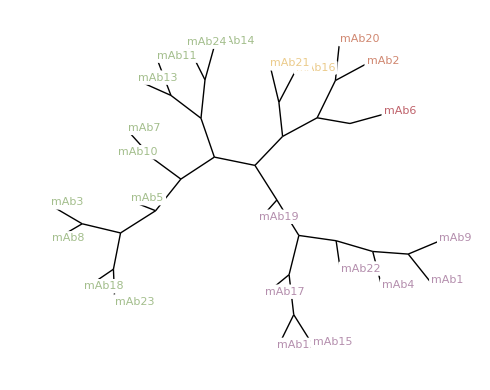

In [ ]:
# 데이터 정규화
df_normalized = (df - df.min()) / (df.max() - df.min())

# 거리 행렬 계산
distance_matrix = pdist(df_normalized, metric="euclidean")

# 계층적 군집화를 통해 트리 생성
linkage_matrix = linkage(distance_matrix, method="average")

# 클러스터 할당 (5개의 주요 그룹으로 분할)
clusters = fcluster(linkage_matrix, t=5, criterion="maxclust")
candidates = df.index.tolist()
label_colors = {
    candidates[i]: nord_colors[clusters[i] % len(nord_colors)] for i in range(len(candidates))
}

# 트리를 NetworkX 그래프로 변환
root, nodes = to_tree(linkage_matrix, rd=True)
G = nx.Graph()


def add_edges(node, parent=None):
    if node is not None:
        G.add_node(node.id, label=candidates[node.id] if node.id < len(candidates) else "")
        if parent is not None:
            G.add_edge(parent.id, node.id)
        add_edges(node.left, node)
        add_edges(node.right, node)


add_edges(root)

# 그래프 시각화
fig, ax = plt.subplots(figsize=(5, 4))
ax.axis("off")
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_edges(G, pos, ax=ax)

# 노드 라벨 추가 (색상 적용)
labels = {n: G.nodes[n]["label"] for n in G.nodes if G.nodes[n]["label"]}
for n in labels:
    plt.text(
        pos[n][0],
        pos[n][1],
        labels[n],
        fontsize=8,
        color=label_colors.get(labels[n], "black"),
        bbox={"facecolor": "white", "edgecolor": "none", "boxstyle": "round,pad=0.2"},
    )

fig.tight_layout()
plt.show()


다양한 실험 결과를 테이블 형태로 보는 것은 정보를 얻는 데 도움이 되지만, 많은 정보를 한눈에 파악하기는 쉽지 않습니다. 하지만 앞선 예시에서처럼 데이터를 시각화하면 후보 항체들이 어떤 무리(클러스터)를 형성하고 있는지 직관적으로 확인할 수 있습니다. 시각화는 데이터를 효과적으로 요약하여 다음과 같은 유용한 정보를 제공합니다.

- 유사성 파악: 어떤 후보 항체들이 서로 비슷한 특성을 나타내는지 시각적으로 보여주어 그룹별 특징을 분석하는 데 용이합니다.
- 이상치 식별: 다른 후보 항체들과 뚜렷하게 구별되는 특성을 가진 이상치를 발견하고, 이에 대한 추가적인 분석이나 실험을 진행할 수 있습니다.
- 선택 근거 제시: 시각화된 결과를 통해 최종 후보 선택의 타당한 근거를 명확하게 제시할 수 있습니다. 예를 들어, 특정 그룹에 속한 후보 항체들이 높은 결합력과 뛰어난 안정성을 보인다는 점을 시각적으로 보여줄 수 있습니다.

# 마치며

위와 같은 시각화 결과를 얻은 후에는 어떤 추가적인 분석이 필요할까요? 일반적으로 다음과 같은 단계를 거치게 됩니다.

1. 그룹별 특성 심층 분석: 시각화된 결과를 바탕으로 각 그룹의 구체적인 특성을 자세히 분석하고, 우리가 목표로 하는 특성을 가진 그룹을 식별합니다.
2. 그룹 내 개별 후보 비교: 선택된 그룹 내의 개별 후보 항체들의 특성을 세밀하게 비교하여 최종적으로 최적의 후보를 선택합니다.

이처럼 데이터 기반 의사 결정은 과학 연구 분야뿐만 아니라 다양한 영역에서 활용될 수 있습니다. 복잡한 문제에 직면했을 때 데이터를 시각화하여 분석한다면, 더욱 효과적이고 합리적인 결정을 내리는 데 큰 도움을 얻을 수 있습니다.